In [1]:
try: import cPickle as pickle
except: import pickle
from os import environ
# if 'DISPLAY' not in environ:
#     import matplotlib
#     matplotlib.use('Agg')

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import itertools
from matplotlib import rc
import numpy as np
import pandas as pd
import seaborn
font = {'family': 'serif', 'serif': ['computer modern roman']}
rc('text', usetex=False)
rc('font', weight='bold')
rc('font', size=8)
rc('lines', markersize=2.5)
rc('lines', linewidth=0.5)
rc('xtick', labelsize=6)
rc('ytick', labelsize=6)
rc('axes', labelsize='small')
rc('axes', labelweight='bold')
rc('axes', titlesize='small')
rc('axes', linewidth=1)
plt.rc('font', **font)
seaborn.set_style("darkgrid")
import pdb

In [2]:
graph_info = pd.read_hdf('graphPropertiesPy3.h5', 'df')

In [3]:
graph_info.columns

Index(['Unnamed: 0', 'index', 'network_index', 'network_name', 'title',
       'description', 'networkDomain', 'subDomain', 'citation', 'sourceUrl',
       'hostedBy', 'graphProperties', 'nodeType', 'edgeType', 'nodes_id',
       'edges_id', 'number_nodes', 'number_edges', 'ave_degree', 'labels_Q',
       'labels_Q_MR', 'labels_Q_MP', 'labels_Q_GMP', 'labels_B_NR_SBM',
       'labels_B_NR_DCSBM', 'labels_B_HKK_SBM', 'labels_cICL_HKK_SBM',
       'labels_Infomap', 'labels_MDL_SBM', 'labels_MDL_DCSBM', 'labels_S_NB',
       'labels_S_cBHm', 'labels_S_cBHa', 'labels_AMOS',
       'labels_AMOS_reliablity', 'labels_LRT_WB_DCSBM', 'Q_score',
       'Q_MR_score', 'Q_MP_score', 'Q_GMP_score', 'B_NR_SBM_score',
       'B_NR_DCSBM_score', 'B_HKK_SBM_score', 'cICL_HKK_SBM_score',
       'Infomap_score', 'MDL_SBM_score', 'MDL_DCSBM_score', 'S_NB_score',
       'S_cBHm_score', 'S_cBHa_score', 'AMOS_score', 'LRT_WB_DCSBM_score'],
      dtype='object')

In [4]:
graph_info.at[0, 'number_edges']

560

In [5]:
len(graph_info.at[0, 'labels_Q'])

934

In [6]:
graph_info.at[296, 'networkDomain']

'Transportation'

In [7]:
def plot_benchmark(domains, graph_attrs, methods, graph_names, s_sch='rw', metric='MAP'):
    df_all = pd.read_hdf('real_results.h5', 'df')
    df_all['# of Nodes'] = df_all['N']
    df_all['Degree'] = df_all['deg']

    if df_all.empty:
        return
    plot_shape = (3, 3)
    fin1, axarray1 = plt.subplots(3, 3, figsize=(7, 4), sharex='col', sharey='row')
    data_idx = 0
    lines =None
    labels = None
    for attr in graph_attrs.keys():
        for attr_val in graph_attrs[attr]:
            plot_idx = np.unravel_index(data_idx, (3, 3))
            data_idx+=1
            df_grouped = df_all[df_all[attr]==attr_val]
            df_grouped = df_grouped[["dim", "Round Id", "LP %s" % metric, "Method", "Graph"]]
            df_grouped['LP %s' % metric] = df_grouped['LP %s' % metric].astype('float')
            df_grouped = df_grouped.groupby(["dim", "Round Id", "Method", "Graph"]).mean().reset_index()
            try:
                df_grouped['unit']=df_grouped.apply(lambda x:'%s_%s' % (x['Round Id'],x['Graph']),axis=1)
            except:
                pdb.set_trace()
            df_grouped = df_grouped.drop(['Round Id', "Graph","unit"], axis=1)
            value = "LP %s" % metric
            palette = {"gf":"#9b59b6", "rand":"#3498db", "pa":"#F08A4B", "lap":"#DE369D", 
                       "hope":"#59CD90", "cn":"#F9ECCC", "aa": "#EFD6D2","sdne":"#EE6352", "jc":"#C6D8FF"}
            marker = {"gf":"o", "rand":"v", "pa":"s", "lap":"P", "hope":"D", "cn":"P", "aa":"*","sdne":"X", "jc":"<"}
            ax = seaborn.lineplot(x="dim", y=value ,err_style="bars", hue="Method",dashes=False,
                                  palette=palette,markers =marker, legend='brief', 
                                  style ="Method", data=df_grouped, ax=axarray1[plot_idx[0], plot_idx[1]])
            ax.set_title(attr+" : "+str(attr_val), pad=-0.1,  fontdict ={'fontsize': 6})
            ax.set_ylabel('')    
            ax.set_xlabel('')
            ax.set_xscale('log', basex=2)
            ax.get_legend().remove()
            for line_i in range(len(ax.lines)):
                ax.lines[line_i].set_markeredgecolor('k')
                ax.lines[line_i].set_markeredgewidth('0.2')
                ax.lines[line_i].set_markersize('3.5')

            if data_idx==9:
                lines,labels = ax.get_legend_handles_labels()

    for col_idx in range(axarray1[2].shape[0]):
        box = axarray1[2][col_idx].get_position()
        axarray1[2][col_idx].set_position(
            [box.x0,
             box.y0 + box.height * 0.1,
             box.width,
             box.height * 0.9]
        )
    line_label ={k:v for k,v in zip(labels,lines)}
#     print(line_label)
    baselines= ["rand","cn", "aa",  "pa","jc"]
    embedding = ["lap","gf",   "hope","sdne"]
    labels = baselines+embedding
    lines =[line_label[k] for k in labels]     
    fin1.legend(lines,labels,loc='lower center', bbox_to_anchor=(0.46,-0.001),#(0.46, -0.01),
                ncol=len(methods)+1, fancybox=True, shadow=True,prop={'size': 6})
    fin1.text(0.5, 0.06, 'Dimension', ha='center', fontdict ={'fontsize': 8})
    fin1.text(0.07, 0.5, metric, va='center', rotation='vertical', fontdict ={'fontsize': 8})
    plt.savefig(
       'benchmark_real_%s.pdf' % metric, # gem/plots/hyp/
       dpi=300, format='pdf', bbox_inches='tight'
    )
    plt.show()
    plt.clf()

86


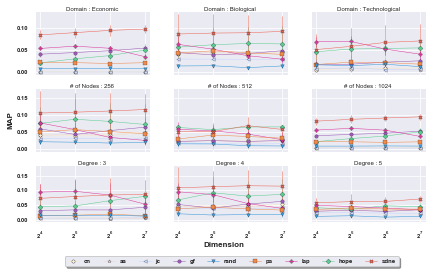

<Figure size 432x288 with 0 Axes>

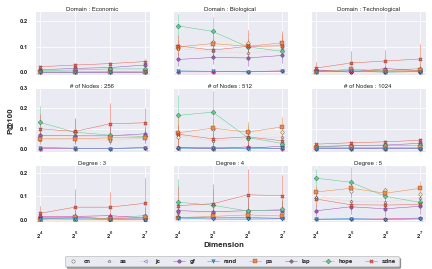

<Figure size 432x288 with 0 Axes>

In [8]:
graph_names = [0, 1, 20, 29, 35, 184, 186, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 216, 217, 218, 219, 220, 221, 222, 224, 225, 230, 231, 232, 233, 234, 235, 236, 237, 238, 240, 241, 242, 243, 244, 245, 246, 250, 322, 324, 359, 378, 379, 380, 381, 382, 383, 384]
graph_names_new = [177, 178, 183, 208, 209, 210, 211, 212, 213, 214, 215, 223, 226, 227, 228, 229, 249, 251, 252, 253, 254, 289, 296]
graph_names += graph_names_new
print(len(graph_names))
plot_benchmark(
    ["Economic", "Biological", "Technological"],
    {"Domain": ["Economic", "Biological", "Technological"], "# of Nodes": [256, 512, 1024], "Degree": [3, 4, 5]},
    ["gf", "rand", "pa", "lap", "hope", "cn", "aa","sdne", "jc"],
    graph_names,
    s_sch='u_rand',
    metric='MAP'
)
plot_benchmark(
    ["Economic", "Biological", "Technological"],
    {"Domain": ["Economic", "Biological", "Technological"], "# of Nodes": [256, 512, 1024], "Degree": [3, 4, 5]},
    ["gf", "rand", "pa", "lap", "hope", "cn", "aa","sdne", "jc"],
    graph_names,
    s_sch='u_rand',
    metric='P@100'
)